In [25]:
import os
home = os.path.expanduser("~")

import numpy as np
import matplotlib.pyplot as plt
import glob
import ipywidgets as widgets
import seaborn as sns
snscolors=sns.color_palette()
snscolors.pop(2)  # take out green
snscolors=np.tile(np.array(snscolors),(10,1))
import scipy
import pickle
import gc
import time
import importlib
import csv

import torch
# torch.set_num_threads(2)

from IPython import display  # used for clearing plots, to view during the simulation:  clear with:    display.clear_output(wait=True)

import pandas as pd
from wpca import PCA

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [26]:
imagedir = '../image-output/'
savefigures = False

# Data Definitions and import

In [27]:
import datafunctions as dfunc


In [28]:
resultdir = 'savedresults/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

# immport combined quantiles
outfile = resultdir+'combinedquantiles.pkl'
[all_speedquantiles10, all_speedquantiles20, all_ndistquantiles, all_bdistquantiles] = pickle.load(open(outfile,'rb'))

numfish=6
    
sel = np.tile(True,numtreatments)
sel[focustreatments] = False
notfocus = np.arange(numtreatments)[sel]
notfocus = notfocus[np.argsort(np.array(treatments)[notfocus])]


focuscolors=['grey' for _ in range(numtreatments)]
for i in range(1,len(focustreatments)):
    focuscolors[focustreatments[i]] = snscolors[i-1 if i<8 else i]
focuscolors[0] = np.array([0.0,0.0,0.0])

treatments_dispnames = np.array([t[:-2] if len(t)>3 else t for t in treatments])

midsize=80.43977  # from an average of the output of Tristan's tracker - 'midline_length', which can be considere the body length
pxpercm = 4.02361434 * 10  # from tracker
dt=1/60

# Read in median results

In [29]:
### load results from pickle file for Trial Quantities

datachoice = 3
# use this line to select all data or not
if (datachoice==0):
    postfix=''
elif datachoice==1:
    postfix='-nooverlap'
elif datachoice==2:
    postfix='-far'
elif datachoice==3:
    postfix='nooverlap-nofreezeforspeed'
else:
    print('error in datachoice number')    

# Load trial quantities
outfile = resultdir + 'Fig2-TrialQuantities'+postfix+'.pkl'
[
trial_speedmedians, trial_speedIQR, trial_nnmedians, trial_cosmedians, trial_groupnums, trial_groupiidmedians, trial_grouppolmedians, 
trial_groupiid_together_medians, trial_grouppol_together_medians,
trial_freezefrac, trial_freezefrac1sec, trial_speedsync, trial_centroiddist, trial_boundarydist, trial_nnrelspeed
] = pickle.load(open(outfile,'rb'))
# Load treatment (line) quantities
outfile = resultdir + 'Fig2-TreatmentQuantities'+postfix+'.pkl'
[
treatment_speedmedians, treatment_speedIQR, treatment_nnmedians, treatment_cosmedians, treatment_groupnums, treatment_groupiidmedians, treatment_grouppolmedians, 
 treatment_groupiid_together_medians, treatment_grouppol_together_medians,
 treatment_freezefrac, treatment_freezefrac1sec, treatment_speedsync, treatment_centroiddist, treatment_boundarydist, treatment_nnrelspeed
] = pickle.load(open(outfile,'rb'))
# calculate this from the trial centroid distributions - its better to do this way.  
treatment_centroiddist = np.array([np.sum(t)/len(t) for t in trial_centroiddist])

# change the units where needed
trial_speedmedians /= pxpercm
trial_speedIQR /= pxpercm
trial_nnmedians /= pxpercm
trial_groupiidmedians /= pxpercm
trial_groupiid_together_medians /= pxpercm
trial_centroiddist /= (pxpercm*dt)
trial_boundarydist /= pxpercm
trial_nnrelspeed /= pxpercm

treatment_speedmedians /= pxpercm
treatment_speedIQR /= pxpercm
treatment_nnmedians /= pxpercm
treatment_groupiidmedians /= pxpercm
treatment_groupiid_together_medians /= pxpercm
treatment_centroiddist /= (pxpercm*dt)
treatment_boundarydist /= pxpercm
treatment_nnrelspeed /= pxpercm

# Load trial quantities
postfix_s = '-nooverlap'
outfile = resultdir + 'Fig2-TrialQuantities'+postfix_s+'.pkl'
trial_speedmedians_all = pickle.load(open(outfile,'rb'))[0]
# Load treatment (line) quantities
outfile = resultdir + 'Fig2-TreatmentQuantities'+postfix_s+'.pkl'
treatment_speedmedians_all = pickle.load(open(outfile,'rb'))[0]

trial_speedmedians_all /= pxpercm
treatment_speedmedians_all /= pxpercm

In [30]:
### SORT ORDER
sortinput = np.array([np.median(t) for t in trial_speedmedians_all] )
speedsortorder = np.argsort(sortinput)
focus_sorted = focustreatments[np.argsort(sortinput[focustreatments])]

# Trial Boxplots

In [17]:

def trialplot(ax,trial_data,mediandata,sortorder,showlegend=False):
    if len(mediandata)==0:
        mediandata = [np.median(t) for t in trial_data]
    bps = []
    for tnum in np.concatenate([focustreatments,notfocus]):  # keep it the concat
    #     tnum = focustreatments[j]
        xval = np.where(sortorder==tnum)[0][0]*0.1-0.3
        bp = ax.boxplot(x=trial_data[tnum],positions=[xval],usermedians=[mediandata[tnum]],patch_artist=True,showfliers=False,showcaps=True,vert=True,widths=0.07)
        for patch in bp['boxes']:
            patch.set(color=focuscolors[tnum],alpha=0.5)  
        for element in ['whiskers', 'fliers', 'medians', 'caps']:
            plt.setp(bp[element], color=focuscolors[tnum])     
        plt.setp(bp["fliers"], markeredgecolor=focuscolors[tnum], markerfacecolor=focuscolors[tnum],markersize=4)
        xnoise=0.01
        xnoise=0
        xtp = np.random.normal(xval,xnoise,size=allnumtrials[tnum])
        ax.scatter(xtp,trial_data[tnum],color=focuscolors[tnum],alpha=0.3,zorder=10)
        if tnum in focustreatments:
            bps.append(bp)
    if showlegend:
        ax.legend([bp["boxes"][0] for bp in bps], treatments_dispnames[focustreatments], bbox_to_anchor=(1, 1),fontsize=14)    
    ax.set_xticks(np.arange(numtreatments)*0.1-0.3)
    ax.tick_params(labelsize=12)
    ax.set_xticklabels(treatments_dispnames[sortorder],fontsize=11,rotation='vertical')
    ax.set_xlim([-0.4,numtreatments*0.1-0.3])

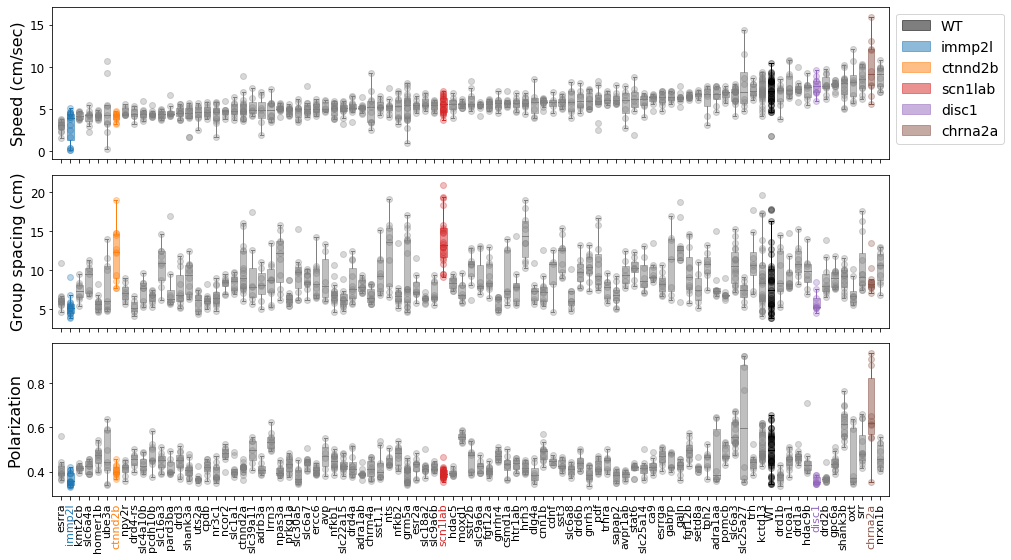

In [18]:
savefigures=False


quantities3 = [trial_speedmedians_all, trial_groupiidmedians, trial_grouppolmedians]
treatment_quantities3 = np.array([treatment_speedmedians_all, treatment_groupiidmedians, treatment_grouppolmedians])
savenameappend=postfix
quantitynames3 = ['Speed (cm/sec)','Group spacing (cm)','Polarization']

f,ax = plt.subplots(3,1,sharex=True)
f.set_size_inches(15,3*3)

for q in range(3):
    a=ax[q]
    trialplot(a,quantities3[q],[],speedsortorder,showlegend=True if q==0 else False)
    a.set_ylabel(quantitynames3[q],fontsize=16)

#     a.set_ylim([np.quantile(np.concatenate(quantities3[q]),0.000),np.quantile(np.concatenate(quantities3[q]),1)])

focus_places  = np.array([np.where(speedsortorder==i)[0][0] for i in focustreatments])
for t in range(len(focustreatments)):
    ax[-1].get_xticklabels()[focus_places[t]].set_color(focuscolors[focustreatments[t]])
#     ax[-1].get_xticklabels()[focus_places[t]].set_fontsize(14)    

plt.subplots_adjust(hspace=0.1)
plt.savefig(imagedir+'TrialBoxPlots'+savenameappend+'.pdf') if savefigures else None
plt.show()

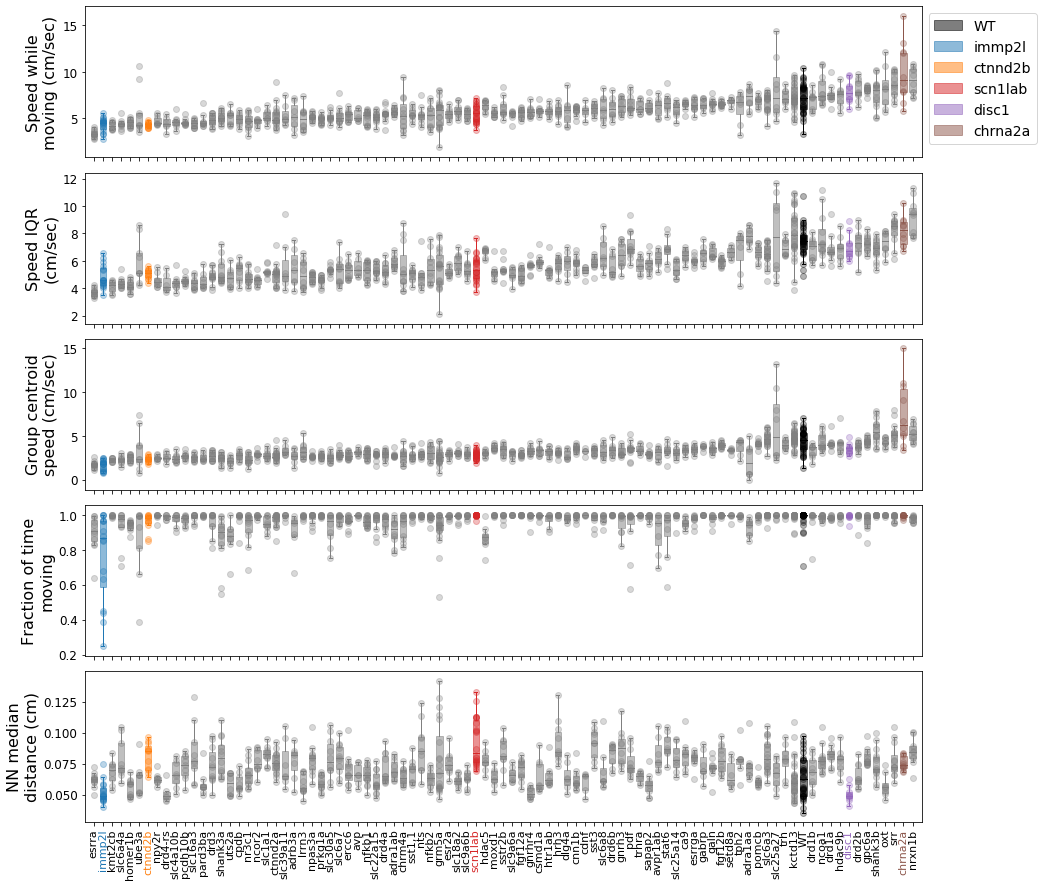

In [19]:

quantities5 = [trial_speedmedians,trial_speedIQR, trial_centroiddist, 1-trial_freezefrac, trial_nnmedians/pxpercm]
# treatment_quantities5 = np.array([treatment_speedmedians,treatment_speedIQR, treatment_centroiddist,  1-treatment_freezefrac, treatment_nnmedians])

quantitynames5 = ['Speed while\nmoving (cm/sec)','Speed IQR\n(cm/sec)', 'Group centroid\nspeed (cm/sec)','Fraction of time\nmoving', 'NN median\ndistance (cm)']
savenameappend='-otherquantities-'+postfix

f,ax = plt.subplots(5,1,sharex=True)
f.set_size_inches(15,5*3)

for q in range(5):
    a=ax[q]
    trialplot(a,quantities5[q],[],speedsortorder,showlegend=True if q==0 else False)
    a.set_ylabel(quantitynames5[q],fontsize=16)

#     a.set_ylim([np.quantile(np.concatenate(quantities3[q]),0.000),np.quantile(np.concatenate(quantities3[q]),1)])

focus_places  = np.array([np.where(speedsortorder==i)[0][0] for i in focustreatments])
for t in range(len(focustreatments)):
    ax[-1].get_xticklabels()[focus_places[t]].set_color(focuscolors[focustreatments[t]])
#     ax[-1].get_xticklabels()[focus_places[t]].set_fontsize(14)    

plt.subplots_adjust(hspace=0.1)
plt.savefig(imagedir+'TrialBoxPlots'+savenameappend+'.pdf') if savefigures else None
plt.show()

# Raster plots and PCA

In [20]:
def embeddingplot(a,px,py,px_trial,py_trial,componentnames,showWTtrials=True,labeltreatments=focustreatments,zerolabels=False,space=[0.015,0.015]):
    cs = np.cumsum(allnumtrials)
    for t in range(numtreatments):
        zz=100 if (t in focustreatments) else 0
        ss = 50 if (t in focustreatments) else 50
        sstrial = 12 if t in focustreatments else 12
        aa = 1 if (t in focustreatments) else 0.3
        a.scatter(px[t],py[t],color=focuscolors[t],zorder=zz,s=ss,alpha=aa)
        if t in ([0] if showWTtrials else [-1]):
            lower = 0 if t==0 else cs[t-1]
            upper = cs[t]            
            a.scatter(px_trial[lower:upper],py_trial[lower:upper],color=focuscolors[t],zorder=zz,alpha=aa,s=sstrial)
        if not zerolabels:
            if t in labeltreatments:
                xspace = (space[0]*(np.max([px]) - np.min([px])) if space[0]==0.015 else space[0])         
                yspace = (space[1]*(np.max([py]) - np.min([py])) if space[1]==0.015 else space[1])     
                a.annotate(treatments[t][:-2] if t>0 else treatments[t], (px[t]+xspace,py[t]-yspace/2),zorder=zz,color=focuscolors[t],fontsize=12 if t in focustreatments else 10,alpha=aa)
    a.axvline(0,c='k')
    a.axhline(0,c='k')    
    a.set_xlabel(componentnames[0],fontsize=16)
    a.set_ylabel(componentnames[1],fontsize=16)
    


    
def plotraster(toplot,quantitynames,vmax=-1,highlightpvalues=False,pvalues=[]):
    if vmax==-1:
        toplot_max = np.max(np.abs(toplot))
    else:
        toplot_max = vmax
    f,ax=plt.subplots(1,1)
    f.set_size_inches(20,3.5*toplot.shape[1]/7)
    x =np.arange(numtreatments+1)
    y = np.flipud(np.arange(toplot.shape[1]+1))
    raster = ax.pcolormesh(x,y,toplot[speedsortorder].T,cmap='magma' if toplot.shape[1]==1 else 'seismic',vmin=-toplot_max,vmax=toplot_max,rasterized=True)
    for t in range(numtreatments):
        for q in range(toplot.shape[1]):
            tnum = speedsortorder[t]
            if highlightpvalues:
                if pvalues[tnum,q]<0.05:
                    x0,x1 = x[t:t+2]  
                    y0,y1 = y[q:q+2]
                    ax.plot([[x0,x1],[x1,x1],[x1,x0],[x0,x0]],[[y0,y0],[y0,y1],[y1,y1],[y1,y0]],
                            c='k',linewidth=2,zorder=10)
    ax.set_yticks(np.arange(toplot.shape[1])+0.5)
    ax.set_xticks(np.arange(numtreatments)+0.5)
    ax.set_xticklabels(treatments_dispnames[speedsortorder],rotation='vertical')
    ax.tick_params(labelsize=13)
    ax.set_yticklabels(np.flipud(quantitynames),fontsize=18)

    focus_places  = np.array([np.where(speedsortorder==i)[0][0] for i in focustreatments])
    for t in range(len(focustreatments)):
        ax.axvline(focus_places[t],c=focuscolors[focustreatments[t]],linewidth=3)
        ax.axvline(focus_places[t]+1,c=focuscolors[focustreatments[t]],linewidth=3)    
        ax.get_xticklabels()[focus_places[t]].set_color(focuscolors[focustreatments[t]])
    #     ax.get_xticklabels()[focus_places[t]].set_fontsize(18)    


    # COLORBAR
    position=f.add_axes([ax._position.bounds[0]+0.79,ax._position.bounds[1]+0.0,.01,0.755])
    cbar=plt.colorbar(raster,ax=ax,cax=position,orientation='vertical')    
    cbar.set_label('Std. deviations from WT',fontsize=16)
    ticks = np.arange(-5,5.5,1)
    cbar.set_ticks(ticks)
    ticks=[str(t) for t in ticks]
    cbar.set_ticklabels(ticks)
    cbar.ax.tick_params(labelsize=14)    
    return f
    
###### PCA COMPONENTS PLOTS
def pcacomponentplots(ax,vh,ylabels):
    xlim = 1.05*np.max(np.abs(vh))
    for evnum in range(vh.shape[0]):
        a=ax[evnum]
        x=vh[evnum]
        y = np.flipud(np.arange(vh.shape[1]))
    #     ax.plot(x,y,'-o',label='$\\vec e_'+str(evnum)+'$: '+str(np.round(pcavar[evnum]*100,1))+'%',c=snscolors[evnum])
        thickness=0.75
        a.barh(y+0*(evnum-1)*thickness,x,height=thickness,color=[0.35,0.35,0.35])
        a.set_yticks(y)
        a.set_yticklabels(ylabels,rotation='horizontal',fontsize=12)
        a.axvline(0,c='k',linestyle='--')
#         a.set_title(label='$\\vec v_'+str(evnum)+'$: '+str(np.round(pcavar[evnum]*100,1))+'%',fontsize=14)
        a.set_xlim([-xlim,xlim])

def pcainputplots(ax,pcamat_treatments,ylabels,focustreatments=focustreatments):
    xlim = 1.05*np.max(np.abs(pcamat_treatments[focustreatments]))
    for t in range(len(focustreatments)-1):
        tnum = focustreatments[t+1]
        a=ax[t]
        x=pcamat_treatments[tnum] - pcamat_treatments[0]
        y = np.flipud(np.arange(pcamat_treatments.shape[1]))
    #     ax.plot(x,y,'-o',label='$\\vec e_'+str(evnum)+'$: '+str(np.round(pcavar[evnum]*100,1))+'%',c=snscolors[evnum])
        thickness=0.75
        a.barh(y,x,height=thickness,color=focuscolors[tnum])
        a.set_yticks(y)
        a.set_yticklabels(ylabels,rotation='horizontal',fontsize=12)
        a.axvline(0,c='k',linestyle='--')
        a.set_title(treatments_dispnames[tnum],fontsize=14)
        
        a.set_xlim([-xlim,xlim])    

def plotremaining(remaining):
    f,ax=plt.subplots(1,1)
    f.set_size_inches(20,1.5)
    for t in range(numtreatments):
        tnum = speedsortorder[t]
        ax.bar(t+1-0.5,remaining[tnum],color=focuscolors[tnum])
    ax.set_xticks(np.arange(numtreatments)+0.5)
    ax.set_xticklabels(treatments_dispnames[speedsortorder],rotation='vertical')    
    ax.set_xlim([0,numtreatments+0])
#     ax.axis('off')
    return f
        
        
################################################        
####### MISC DATA AND FITTING FUNCTIONS ########        
################################################
def sigmoidfn(x,b,c):
    return 1/(1+np.exp(-b*(x-c)))

def IQR(x,axis=-1):
    return np.quantile(x,0.75,axis=axis)-np.quantile(x,0.25,axis=axis)

def nofn(x,axis):
    return 1

def expfn(x,a,b,fnmax=1):
    return fnmax - np.exp(-a*(x-b))

def slopefn(x, a):
    return a*x

def linfn(x, a, b):
    return a*x + b

normvec = lambda x: x/np.linalg.norm(x)

def divtrials(trialdata):
    cs = np.cumsum(allnumtrials)
    triallist = []
    for t in range(numtreatments):
        lower = 0 if t==0 else cs[t-1]
        upper = cs[t] 
        triallist.append(trialdata[lower:upper])
    return triallist

def sampletreatmentq(quantities):
    samplings = [np.random.choice(np.arange(n),n) for n in allnumtrials]
    return np.array([[np.median(t[sample]) for t,sample in zip(q,samplings)] for q in quantities])

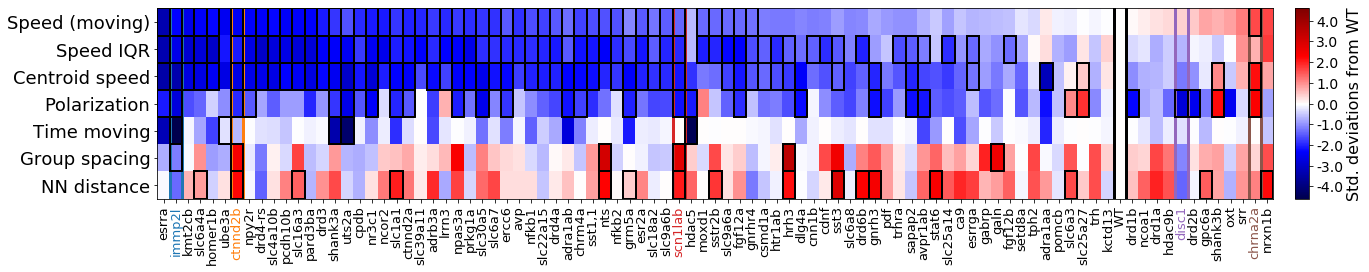

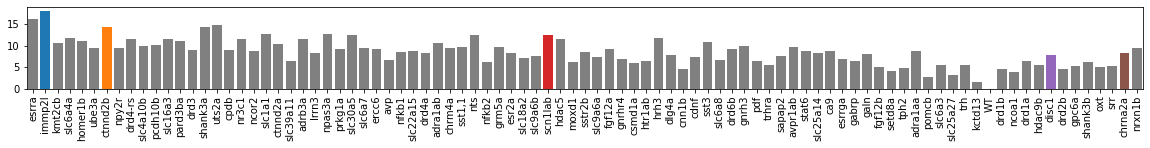

         QUANTITY FUNCTION USED
0  Speed (moving)           lin
1       Speed IQR           lin
2  Centroid speed           lin
3    Polarization           lin
4     Time moving           exp
5   Group spacing           lin
6     NN distance           lin


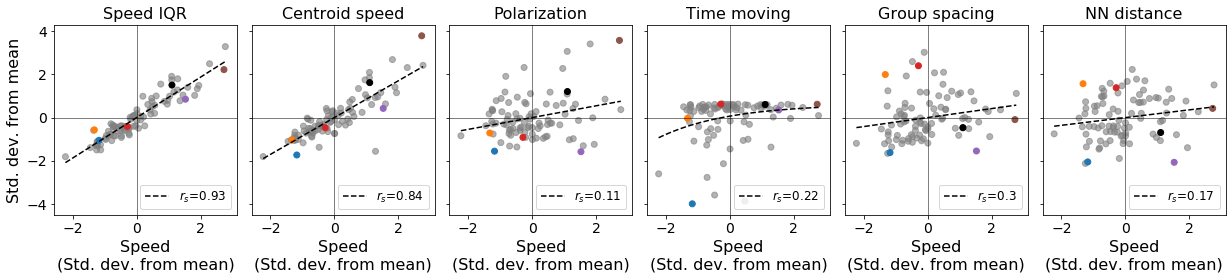

variance_explained_by_speed: 0.40106135909084006
variance_NOT_explained_by_speed: 0.5989386409091599


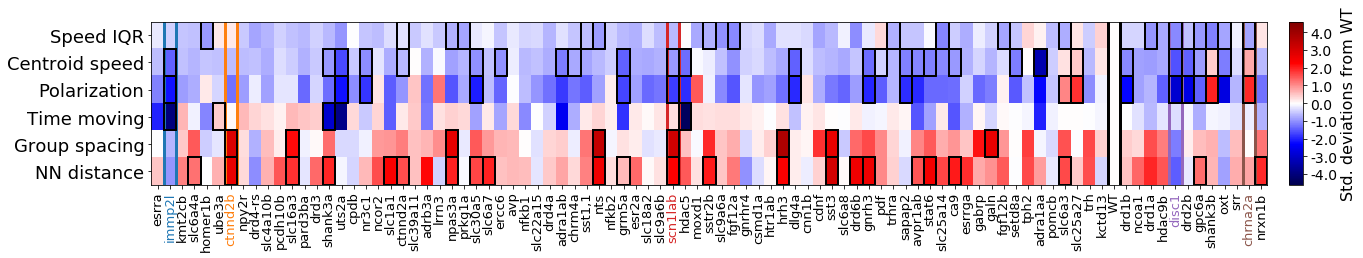

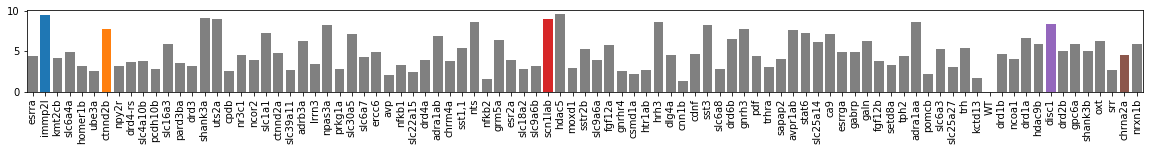

variance explained, SVD PCA:  [0.4117 0.3457 0.1507 0.0484]
variance explained, PCA:  [0.4117 0.3457 0.1507 0.0484]
sum of first three:  0.9081380116832054
variance explained: 0.9081380116832053


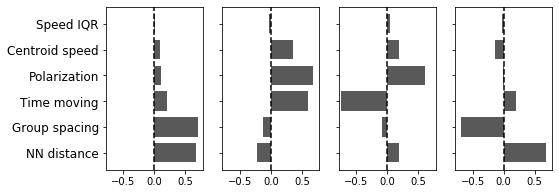

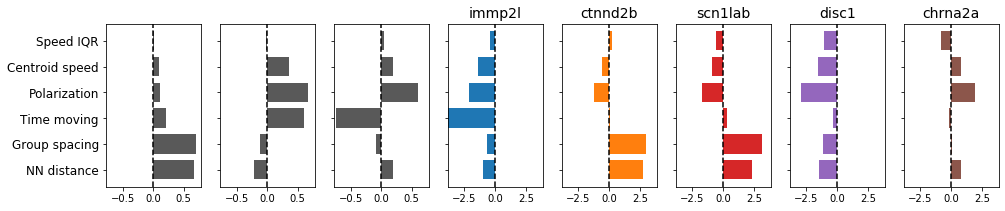

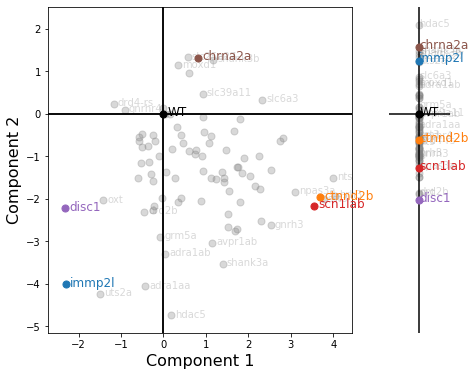

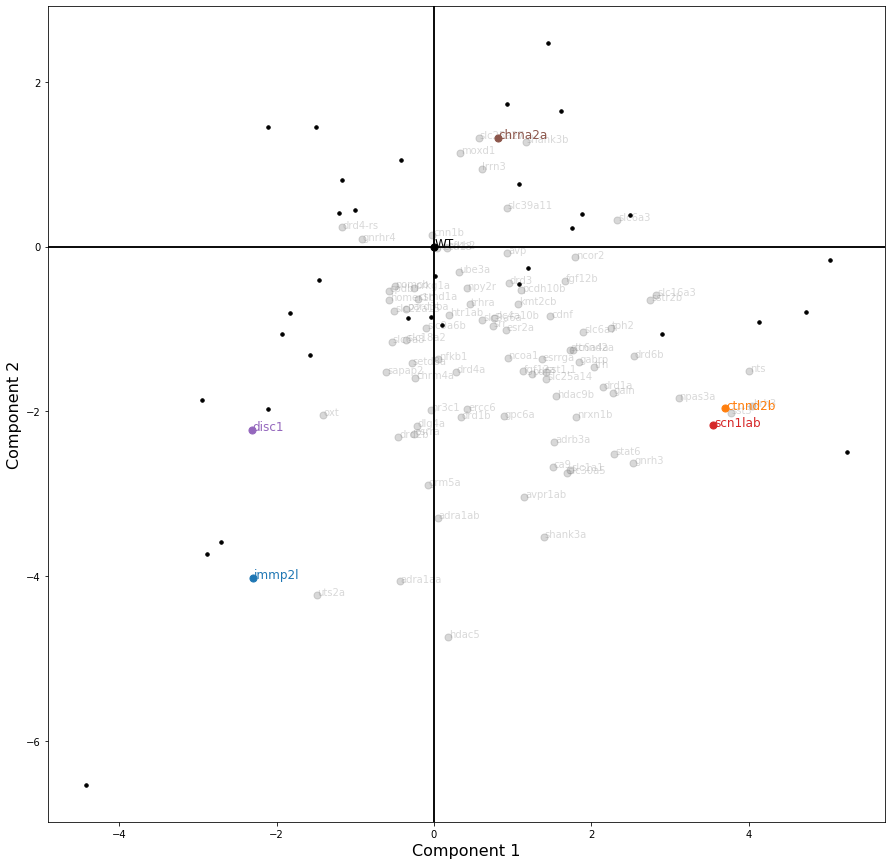

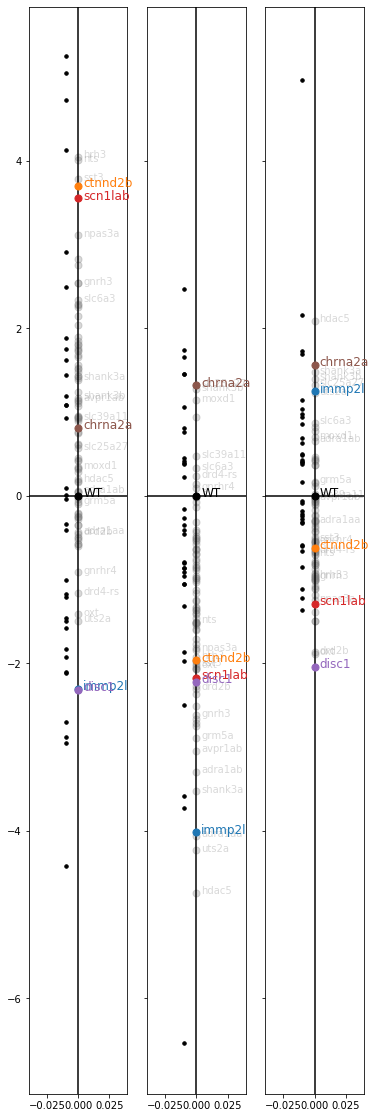

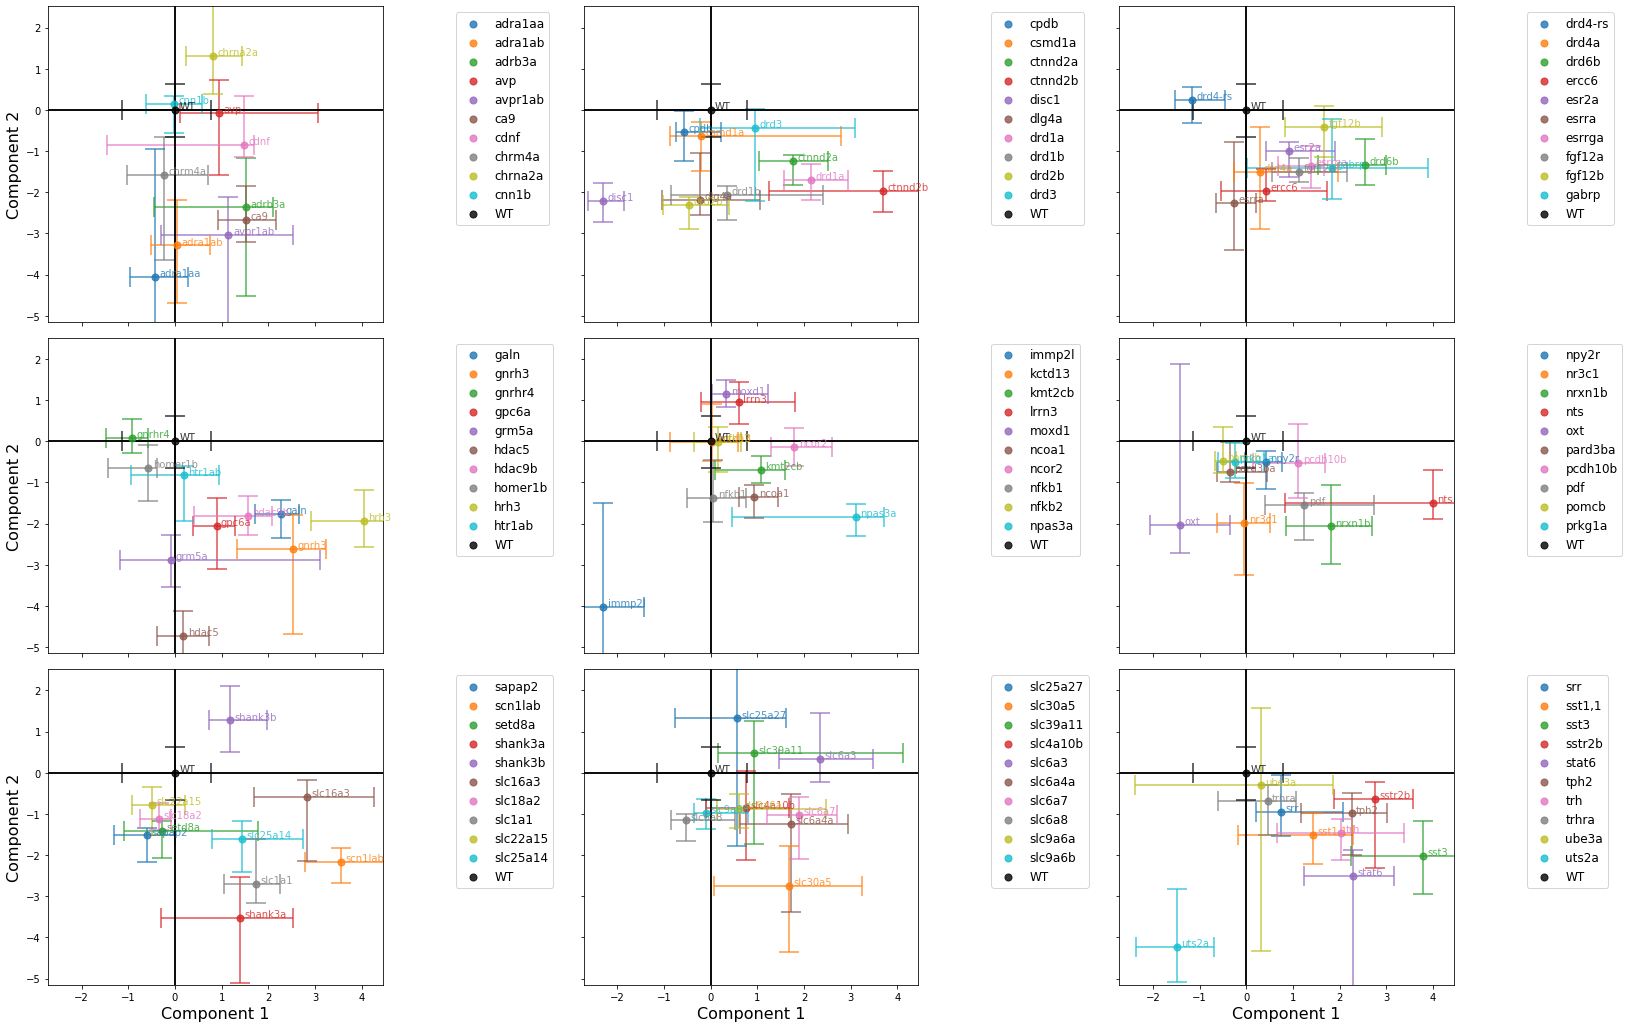

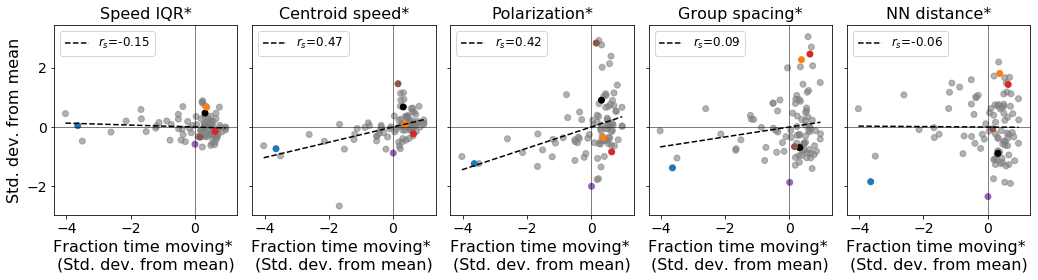

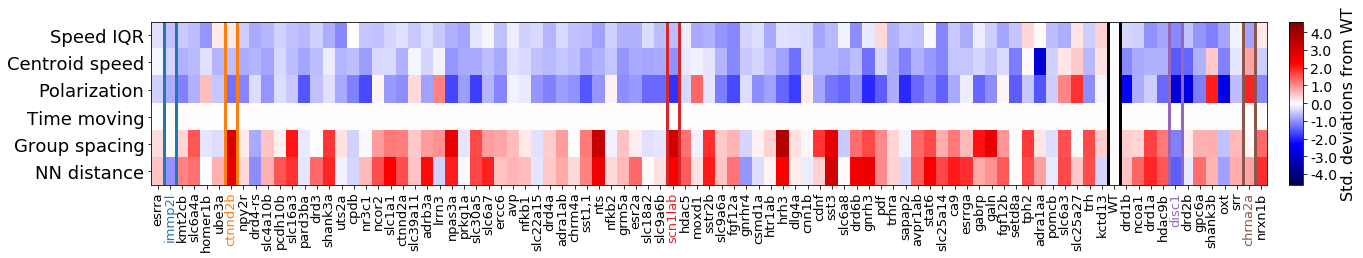

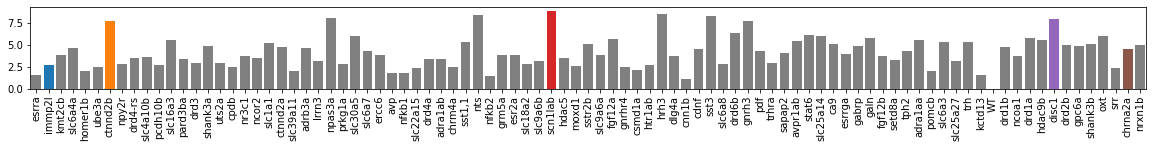

variance explained, PCA:  [0.5588 0.312  0.0691 0.0409]
corrected variance explained:  [0.4043 0.2257 0.2764]
sum of first three:  0.9064589112020593
variance explained: 0.9064589112020592


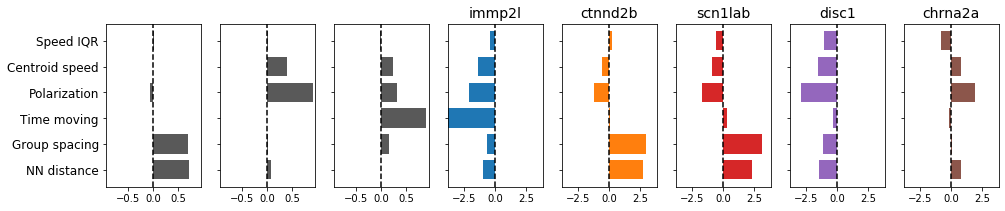

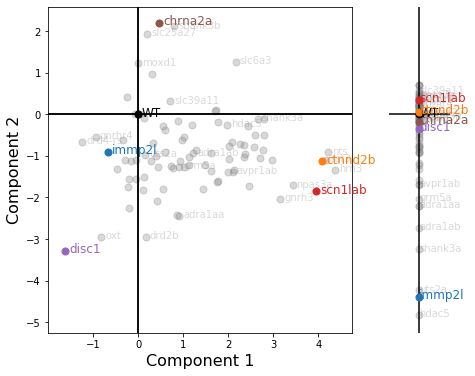

In [24]:
savefigures=False

highlightpvalues = True
    
quantities = [trial_speedmedians, trial_speedIQR, trial_centroiddist, trial_grouppolmedians, 
              1-trial_freezefrac, trial_groupiidmedians,trial_nnmedians]
# treatment_quantities = np.array([treatment_speedmedians, treatment_speedIQR, treatment_centroiddist, treatment_grouppolmedians, 
#                 1-treatment_freezefrac,  treatment_groupiidmedians, treatment_nnmedians])
treatment_quantities = np.array([[np.median(t) for t in q] for q in quantities])
numsample = 1000
treatment_quantities_sampled = np.array([sampletreatmentq(quantities) for _ in range(numsample)])

quantitynames = ['Speed (moving)','Speed IQR', 'Centroid speed', 'Polarization',
                 'Time moving', 'Group spacing','NN distance']

otherhighlighted = ['nts','sst3','hrh3','oxt','drd2b','drd1b','npas3a','gnrh3',
                     'sapap2','drd4-rs','gnrhr4','slc6a3','shank3b','slc25a27','moxd1',
                    'hdac5','uts2a','avpr1ab','shank3a','adra1ab','adra1aa','esrra']
label_scattered = ['hrh3','nts','sst3','npas3a','gnrh3','drd2b']
label_huddled = ['hdac5','uts2a','adra1aa','shank3a','adra1ab','oxt','avpr1ab','drd4-rs','gnrhr4','grm5a']
label_coherent = ['slc25a27','shank3b','moxd1','slc39a11','slc6a3']

otherhighlighted = np.concatenate((label_scattered,label_huddled,label_coherent))
otherlabels = [np.where(treatments_dispnames==t)[0][0] for t in otherhighlighted]

tolabel=np.concatenate((focustreatments,otherlabels))

## Import Statistical Test results from Kati's analysis
if highlightpvalues:
    pvalues = np.array(pd.read_csv(resultdir+'dunnett-raw.csv',header=None)).T
    pvalues[0] = 1  # set to 1 for WT
    pvalues_s = np.array(pd.read_csv(resultdir+'dunnett-speedsubtracted.csv',header=None)).T
    pvalues_s[0] = 1  # set to 1 for WT    
    pvalues_f = np.array(pd.read_csv(resultdir+'dunnett-speedandfreezingsubtracted.csv',header=None)).T
    pvalues_f[0] = 1  # set to 1 for WT        
    pvalues_f[:,3] = 1 # set to 1 for column with fraction of time moving

# create figure if saving
if savefigures:
    import matplotlib.backends.backend_pdf
    pdf = matplotlib.backends.backend_pdf.PdfPages(imagedir+'Figs-Data-MEDIAN.pdf')

####################################################################################################################################################
### PCA matrix with all quantities 
####################################################################################################################################################
# PCA matrix definitions, and normalization
pcamat_treatments = treatment_quantities[:].copy().T
pcamat_trials = np.array([(np.concatenate(q)) for q in quantities.copy()]).T
pcamat_sampled = treatment_quantities_sampled.T

colmean = np.mean(pcamat_treatments,axis=0)
colnorm = np.std(pcamat_treatments,axis=0)

pcamat_treatments = (pcamat_treatments - colmean)/colnorm
pcamat_trials = (pcamat_trials - colmean)/colnorm
pcamat_sampled = (pcamat_sampled - colmean[np.newaxis,:,np.newaxis])/colnorm[np.newaxis,:,np.newaxis]

# output to file:
outputprefix = 'raw'
for i in range(pcamat_treatments.shape[1]):
    csv.writer(open(resultdir+'csvoutput/'+outputprefix+'-q'+str(i)+'.csv', 'w'),delimiter=',').writerows(divtrials(pcamat_trials[:,i]))  

# make a raster plot of this, 
# toplot = np.zeros((numtreatments,len(quantities)+1))
# spdtp = (treatment_speedmedians_all - np.mean(treatment_speedmedians_all))/np.std(treatment_speedmedians_all)
# toplot[:,0] = spdtp
# toplot[:,1:] = pcamat_treatments.copy()
# toplot-= toplot[0,:]
# f = plotraster(toplot,np.concatenate((['Speed'],quantitynames)))
# pdf.savefig(f) if savefigures else None
# plt.show()

toplot = pcamat_treatments.copy()
toplot-= toplot[0,:]
rastermax = np.max(np.abs(toplot))
f = plotraster(toplot,quantitynames,vmax=rastermax,highlightpvalues=highlightpvalues,pvalues=pvalues if highlightpvalues else [])
pdf.savefig(f) if savefigures else None

remaining1 = np.sum(np.abs(toplot),axis=1)
f = plotremaining(remaining1)
pdf.savefig(f) if savefigures else None
plt.show()


####################################################################################################################################################
### Speed model, trends, and variance explained
####################################################################################################################################################
fndef = np.array(['lin','lin','lin','lin','exp','lin','lin'])
print(pd.DataFrame(np.array([quantitynames,fndef]).T,columns=['QUANTITY','FUNCTION USED']))

basesize=3.5
f,ax = plt.subplots(1,len(quantities)-1,sharex=True,sharey=True)
f.set_size_inches(basesize*(len(quantities)-1),basesize*1)

fits=[]
spd = pcamat_treatments[:,0]
spd_trials = pcamat_trials[:,0]
spd_sampled = pcamat_sampled[:,0,:]
xtp = np.linspace(np.min(spd),np.max(spd),100)
Xstar = np.zeros(pcamat_treatments.shape) # speed model predictions (X*)
Xstar_trials = np.zeros(pcamat_trials.shape) # speed model predictions (X*)
Xstar_sampled = np.zeros(pcamat_sampled.shape)
for i in range(len(quantitynames)):
    q = pcamat_treatments[:,i]
    if fndef[i]=='exp':
        def fn(x,a,b):
            return expfn(x,a,b,fnmax=np.max(q))
    else:
        fn = slopefn
        # note that for the slope fits, this gives the same thing, because of the normalization:  np.dot(q,spd)/numtreatments
    popt, pcov = scipy.optimize.curve_fit(fn,spd,q)
    fits.append(popt)
    
    # define the speed model predictions
    Xstar[:,i] = fn(spd,*popt)
    Xstar_trials[:,i] = fn(spd_trials,*popt)
    Xstar_sampled[:,i,:] = fn(spd_sampled,*popt)
    
    # plot this fit
    if i>0:
        a = ax[i-1]
        a.scatter(spd[notfocus],q[notfocus],c=np.array(focuscolors)[notfocus],alpha=0.6)
        a.scatter(spd[focustreatments],q[focustreatments],c=np.array(focuscolors)[focustreatments],alpha=1)  
        corr = scipy.stats.spearmanr(spd,q)[0]
        a.plot(xtp,fn(xtp,*popt),c='k',linestyle='--',label='$r_s$='+str(np.round(corr,2)))
        a.set_title(quantitynames[i],fontsize=16)
        a.set_xlabel('Speed\n(Std. dev. from mean)',fontsize=16)    
        a.axvline(0,c='k',linewidth=0.5)
        a.axhline(0,c='k',linewidth=0.5)
        a.tick_params(labelsize=14)
        a.legend(fontsize=12,loc=4)

ax[0].set_ylabel('Std. dev. from mean',fontsize=16)    
plt.subplots_adjust(wspace=0.08,hspace=0.07)
pdf.savefig(f) if savefigures else None
plt.show()

# Variance explained by speed
# this is straightforward, because the matrix has already been normalized, and contains all the components
variance_explained_by_speed = np.linalg.norm(Xstar)**2 / np.linalg.norm(pcamat_treatments)**2
# its better to calculate this way - because if somee of the treatments have values with negative corrrelations (which is only a few), then its different
variance_not_explained_by_speed = np.linalg.norm(pcamat_treatments - Xstar)**2 / np.linalg.norm(pcamat_treatments)**2
print('variance_explained_by_speed:',1-variance_not_explained_by_speed)
print('variance_NOT_explained_by_speed:',variance_not_explained_by_speed)

####################################################################################################################################################
### Create the speed-subtracted matrix, and make a new raster plot
####################################################################################################################################################
pcamat_treatments = pcamat_treatments[:,1:] - Xstar[:,1:]
pcamat_trials = pcamat_trials[:,1:] - Xstar_trials[:,1:]
pcamat_sampled = pcamat_sampled[:,1:,:] - Xstar_sampled[:,1:,:]

# resubtract the column mean, because it will be nonzero for the ones where used a nonlinear function
colmean = np.mean(pcamat_treatments,axis=0)
pcamat_treatments -= colmean
pcamat_trials -= colmean
pcamat_sampled -= colmean[np.newaxis,:,np.newaxis]

# output to file:
outputprefix = 'speedsubtracted'
for i in range(pcamat_treatments.shape[1]):
    csv.writer(open(resultdir+'csvoutput/'+outputprefix+'-q'+str(i)+'.csv', 'w'),delimiter=',').writerows(divtrials(pcamat_trials[:,i]))   

toplot = pcamat_treatments.copy()
toplot -= toplot[0,:]
f = plotraster(toplot,quantitynames[1:],vmax=rastermax,highlightpvalues=highlightpvalues,pvalues=pvalues_s if highlightpvalues else [])
pdf.savefig(f) if savefigures else None
plt.show()

remaining2 = np.sum(np.abs(toplot),axis=1)
f = plotremaining(remaining2)
pdf.savefig(f) if savefigures else None
plt.show()

####################################################################################################################################################
### PCA - on speed-subtracted data matrix ###
####################################################################################################################################################

numev=4
# #  PCA using SVD
u, s, vh = np.linalg.svd(pcamat_treatments, full_matrices=True)
pcavar = s[0:numev]**2/np.sum(s**2)
np.set_printoptions(suppress=True)
print('variance explained, SVD PCA: ', np.round(pcavar,4))

# Weighted PCA, from https://github.com/jakevdp/wpca/
# kwds = {'weights': weightmatrix_treatments}  # not using this anymore.. so just doing regular pca
pca = PCA(n_components=numev).fit(pcamat_treatments)#, **kwds)    
vh = pca.components_
u = pca.transform(pcamat_treatments)
pcavar = pca.explained_variance_ratio_
print('variance explained, PCA: ', np.round(pcavar,4))
print('sum of first three: ',np.sum(pcavar[:3]))

test = np.dot(u[:,0:3],vh[0:3])
print('variance explained:' , 1-np.linalg.norm(pcamat_treatments - test)**2/np.linalg.norm(pcamat_treatments)**2)


vh[2] = -vh[2]
u[:,2] = - u[:,2]

###### DATA PCA COMPONENTS PLOT
numev_toshow=4
f,ax = plt.subplots(1,numev_toshow,sharex=True,sharey=True)
f.set_size_inches(2*numev_toshow,3)
pcacomponentplots(ax,vh[:numev_toshow],quantitynames[1:])
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()

###### COMBO OF PCA COMPONENTS AND INPUTS PLOTTED TOGETHER
f,ax = plt.subplots(1,len(focustreatments)-1+3,sharex=False,sharey=True)
f.set_size_inches(2*(len(ax)),3)

pcacomponentplots(ax[0:3],vh[:3],quantitynames[1:])
pcainputplots(ax[3:],pcamat_treatments,quantitynames[1:])
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()

###### PCA EMBEDDING PLOTS
u_treatment = u.copy()
u_trial = np.array([np.dot(pcamat_trials,v) for v in vh]).T

# subtract WT:
WToffset = u_treatment[0,:].copy()
u_treatment = u_treatment - WToffset
u_trial = u_trial - WToffset
u_sampled = np.array([np.dot(pcamat_sampled[:,:,i],vh.T).T for i in range(numsample)]).T - WToffset[np.newaxis,:,np.newaxis]
u_sampled_low = np.quantile(u_sampled,0.05,axis=-1)
u_sampled_high = np.quantile(u_sampled,0.95,axis=-1)

## 2D+1 embedding - single plot
f,ax = plt.subplots(1,2,sharex=False,sharey=True,gridspec_kw={'width_ratios': [5, 1]})
basesize=6
# basesize=8
f.set_size_inches(basesize*6/5,basesize)    
a=ax[0]
embeddingplot(a,u_treatment[:,0], u_treatment[:,1], u_trial[:,0], u_trial[:,1],['Component 1', 'Component 2'],labeltreatments=tolabel,showWTtrials=False)
a.axvline(0,c='k')
a.axhline(0,c='k')
a=ax[1]
xvals = np.zeros(numtreatments)
xvals[0] = 0
embeddingplot(a,xvals, u_treatment[:,2], 0*u_trial[:,0]-0.02,u_trial[:,2],['', ''],labeltreatments=tolabel,zerolabels=False,showWTtrials=False)
a.axis('off')
pdf.savefig(f,boundingbox='tight')  if savefigures else None
xlim_embeddingplot = ax[0].get_xlim()
ylim_embeddingplot = ax[0].get_ylim()
plt.show()

## expanded embeddings and plots for supplementary
# single 2D
f,ax = plt.subplots(1,1)
basesize=15
f.set_size_inches(basesize,basesize)    
a=ax
embeddingplot(a,u_treatment[:,0], u_treatment[:,1], u_trial[:,0], u_trial[:,1],['Component 1', 'Component 2'],
              labeltreatments=np.arange(numtreatments),showWTtrials=True,space=[0.01,0.01])
a.axvline(0,c='k')
a.axhline(0,c='k')
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()

# 3 x 1D axes
f,ax = plt.subplots(1,3,sharex=False,sharey=True)
basesize=6
# basesize=8
f.set_size_inches(basesize,20)    
xvals = np.zeros(numtreatments)
xvals[0] = 0
for j in range(3):
    a=ax[j]
    embeddingplot(a,xvals, u_treatment[:,j], 0*u_trial[:,j]-0.01, u_trial[:,j],['', ''],labeltreatments=tolabel,zerolabels=False,showWTtrials=True,space=[0.004,0.02])
# a.axis('off')
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()

# error bar plots, from bootstrapping procedure
def embeddingplot_limited(a,px,py,ex,ey,toshow,space=[0.015,0.015]):
    count=0
    clrs = sns.color_palette()
    # include WT as black
    clrs.append('k')
    toshow = np.append(toshow,0)
    for t in toshow:
        zz=100
        ss = 50
        sstrial = 12
        aa = 0.8
        # plot the point
        a.scatter(px[t],py[t],color=clrs[count],zorder=zz,s=ss,alpha=aa,label=treatments_dispnames[t]) 
        # plot the error bars
        a.errorbar(px[t],py[t], xerr = ex[:,t,np.newaxis], yerr=ey[:,t,np.newaxis], fmt='none',
           capsize=10,capthick=1.5,barsabove=(True if t==0 else False),ecolor=clrs[count],alpha=0.8)        
        # annotation
        xspace = (space[0]*(np.max([px]) - np.min([px])) if space[0]==0.015 else space[0])         
        yspace = (space[1]*(np.max([py]) - np.min([py])) if space[1]==0.015 else space[1])     
        a.annotate(treatments[t][:-2] if t>0 else treatments[t], (px[t]+xspace,py[t]-yspace/2),zorder=zz,color=clrs[count],fontsize=10,alpha=aa)
        count+=1
    a.axvline(0,c='k')
    a.axhline(0,c='k')    
    
showorder = np.delete(speedsortorder,np.where(speedsortorder==0))  # speed order
showorder = np.argsort(treatments)[1:]  # alphabetical
xerr = np.array([u_treatment[:,0] - u_sampled_low[:,0],u_sampled_high[:,0] - u_treatment[:,0]])
yerr = np.array([u_treatment[:,1] - u_sampled_low[:,1],u_sampled_high[:,1] - u_treatment[:,1]])


pereach=10
f,ax = plt.subplots(3,3,sharex=True,sharey=True)
plt.subplots_adjust(hspace=0.05,wspace=0.6)
basesize=6
f.set_size_inches(basesize*3*1.4,basesize*3)    
for pnum in range(9):    
    a=ax[np.floor(pnum/3).astype(int),np.mod(pnum,3)]
    embeddingplot_limited(a,u_treatment[:,0], u_treatment[:,1],xerr,yerr,toshow=showorder[pnum*pereach:(pnum+1)*pereach],space=[0.015,-0.035])
    a.axvline(0,c='k')
    a.axhline(0,c='k')
    a.legend(fontsize=12,bbox_to_anchor=(1.2, 1))

ax[0,0].set_xlim(xlim_embeddingplot)
ax[0,0].set_ylim(ylim_embeddingplot)
[a.set_xlabel('Component 1',fontsize=16) for a in ax[-1]]
[a.set_ylabel('Component 2',fontsize=16) for a in ax[:,0]]

pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()    



####################################################################################################################################################
### Freezing model ###
####################################################################################################################################################

# get correlation matrix
n = pcamat_treatments.shape[1]
C_AB = np.zeros((n,n))
spearman_AB = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        C_AB[i,j],_ = scipy.optimize.curve_fit(slopefn,pcamat_treatments[:,i],pcamat_treatments[:,j])
        spearman_AB[i,j],_ = scipy.stats.spearmanr(pcamat_treatments[:,i],pcamat_treatments[:,j])
        
# get the 'X*' predictions, for each one
i_sub = 3

# dont do this - it artifically makes it seem like fraction of time moving explains a lot, just because of correlation with polarization
# u_freezing = np.dot(pcamat_treatments,normvec(C_AB[i_sub]))  # JD
# u_freezing_trials = np.dot(pcamat_trials,normvec(C_AB[i_sub]))
# Xs = u_freezing[:,np.newaxis]*normvec(C_AB[i_sub])[np.newaxis,:]
# Xs_trials = u_freezing_trials[:,np.newaxis]*normvec(C_AB[i_sub])[np.newaxis,:]

Xs = pcamat_treatments[:,i_sub,np.newaxis]*C_AB[np.newaxis,i_sub]
Xs_trials = pcamat_trials[:,i,np.newaxis]*C_AB[np.newaxis,i_sub]

pcamat_treatments_2 = pcamat_treatments.copy() - Xs
pcamat_trials_2 = pcamat_trials.copy() - Xs_trials

var_sub = 1-np.linalg.norm(pcamat_treatments_2)**2/np.linalg.norm(pcamat_treatments)**2

## Plot the correlation with freezing
basesize=3.5
f,ax = plt.subplots(1,5,sharex=True,sharey=True)
f.set_size_inches(basesize*(5),basesize*1)

fits=[]


freeze = pcamat_treatments[:,i_sub]
xtp = np.linspace(np.min(freeze),np.max(freeze),100)
for count in range(pcamat_treatments.shape[1]-1):
    if count<i_sub:
        i=count
    else:
        i=count+1
    
    q = pcamat_treatments[:,i]
    a=ax[count]

    a.scatter(freeze[notfocus],q[notfocus],c=np.array(focuscolors)[notfocus],alpha=0.6)
    a.scatter(freeze[focustreatments],q[focustreatments],c=np.array(focuscolors)[focustreatments],alpha=1)  
    corr = spearman_AB[i_sub,i]
    a.plot(xtp,slopefn(xtp,C_AB[i_sub,i]),c='k',linestyle='--',label='$r_s$='+str(np.round(corr,2)))
    a.set_title(quantitynames[i+1]+'*',fontsize=16)
    a.set_xlabel('Fraction time moving* \n(Std. dev. from mean)',fontsize=16)    
    a.axvline(0,c='k',linewidth=0.5)
    a.axhline(0,c='k',linewidth=0.5)
    a.tick_params(labelsize=14)
    a.legend(fontsize=12)

ax[0].set_ylabel('Std. dev. from mean',fontsize=16)    
plt.subplots_adjust(wspace=0.08,hspace=0.07)
pdf.savefig(f) if savefigures else None
plt.show()



# output to file:
outputprefix = 'speedandfreezingsubtracted'
for i in range(pcamat_treatments_2.shape[1]):
    csv.writer(open(resultdir+'csvoutput/'+outputprefix+'-q'+str(i)+'.csv', 'w'),delimiter=',').writerows(divtrials(pcamat_trials_2[:,i]))   

toplot = (pcamat_treatments_2.copy() - pcamat_treatments_2[0,:])
f = plotraster(toplot,quantitynames[1:],vmax=rastermax,highlightpvalues=False,pvalues=pvalues_f if highlightpvalues else [])
pdf.savefig(f) if savefigures else None
plt.show()

remaining3 = np.sum(np.abs(toplot),axis=1)
f = plotremaining(remaining3)
pdf.savefig(f) if savefigures else None
plt.show()


####################################################################################################################################################
### PCA - orthogonal to freezing ###
####################################################################################################################################################

# PCA, from https://github.com/jakevdp/wpca/
# kwds = {'weights': weightmatrix_treatments}  # not using this anymore.. so just doing regular pca
pca = PCA(n_components=numev).fit(pcamat_treatments_2)#, **kwds)    
vh = pca.components_
u = pca.transform(pcamat_treatments_2)
pcavar = pca.explained_variance_ratio_
print('variance explained, PCA: ', np.round(pcavar,4))

corrected_var = np.concatenate((pcavar[:2]*(1-var_sub),[var_sub]))

print('corrected variance explained: ', np.round(corrected_var,4))
print('sum of first three: ',np.sum(corrected_var))

# vh[0] = -vh[0]
# u[:,0] = - u[:,0]

# make the third component the normalized version the the projection to fraction 
vhtp = vh[0:3].copy()
vhtp[2] = normvec(C_AB[i_sub])

u_treatment_f = u[:,0:3].copy()
u_trial_f = np.array([np.dot(pcamat_trials,v) for v in vhtp[0:3]]).T
u_trial_f[:,2] = pcamat_trials[:,i_sub]*np.linalg.norm(C_AB[i_sub])

u_treatment_f[:,0] =  np.dot(pcamat_treatments_2,vhtp[0])
u_treatment_f[:,1] =  np.dot(pcamat_treatments_2,vhtp[1])
# the 3rd component is NOT the projection, because of how it is defined
u_treatment_f[:,2] = pcamat_treatments[:,i_sub]*np.linalg.norm(C_AB[i_sub])

var_each=[1 - np.linalg.norm(pcamat_treatments - np.dot(u_treatment_f[:,j,np.newaxis],vhtp[np.newaxis,j]))**2/np.linalg.norm(pcamat_treatments)**2 for j in range(3)]

prediction = np.dot(u_treatment_f[:,0:3],vhtp[0:3])
print('variance explained:' , 1-np.linalg.norm(pcamat_treatments - prediction)**2/np.linalg.norm(pcamat_treatments)**2)

# subtract WT:
WToffset = u_treatment_f[0,:].copy()
u_treatment_f = u_treatment_f - WToffset
u_trial_f = u_trial_f - WToffset


## output 'remaining'
qs = [treatments_dispnames,remaining1,remaining2,remaining3,u_treatment[:,0],u_treatment[:,1],u_treatment[:,2]]
qsnames = ['','diff-from-WT','diff-from-WT-after-speed','diff-from-WT-after-freezing','component_1','component_2','component_3']
qs = [treatments_dispnames,u_treatment[:,0],u_treatment[:,1],u_treatment[:,2]]
qsnames = ['','component_1','component_2','component_3']
# csv.writer(open(resultdir+'csvoutput/'+'diff_and_projections.csv','w'),delimiter=',').writerows(np.concatenate(([qsnames],np.array(qs).T)))

orderoutput = []
orderoutputnames = []
def rgb2hex(c):
    r,g,b = c
    return "{:02x}{:02x}{:02x}".format(r,g,b)


def addformatting(q):
    qc = q.copy().astype(list)
    for t in focustreatments:
        qc[t] = '\\textcolor[HTML]{'+rgb2hex(np.floor(focuscolors[t]*255).astype(int))+'}{\\textbf{'+str(q[t])+ '}}'
    return qc

for q, qn in zip(qs[1:],qsnames[1:]):
    order = np.flipud(np.argsort(q))
    orderoutput.append(addformatting(treatments_dispnames)[order])
    orderoutput.append(addformatting(np.round(q,2))[order])
    orderoutputnames.append(qn)
    orderoutputnames.append('')
# csv.writer(open(resultdir+'csvoutput/'+'diff_and_projections-names.csv','w'),delimiter=',').writerows(np.concatenate(([orderoutputnames],np.array(orderoutput).T)))
np.savetxt(resultdir+''+'diff_and_projections-names.tex',np.concatenate(([orderoutputnames],np.array(orderoutput).T)).astype('str'),delimiter=' & ', newline=' \\\\\n',fmt='%s')



###### COMBO OF PCA COMPONENTS AND INPUTS PLOTTED TOGETHER
f,ax = plt.subplots(1,len(focustreatments)-1+3,sharex=False,sharey=True)
f.set_size_inches(2*(len(ax)),3)
pcacomponentplots(ax[0:3],vhtp[:3],quantitynames[1:])
pcainputplots(ax[3:],pcamat_treatments,quantitynames[1:])
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()

###### PCA EMBEDDING PLOTS
WTzero = pcamat_treatments[0,i_sub]

## 2D+1 embedding - single plot
f,ax = plt.subplots(1,2,sharex=False,sharey=True,gridspec_kw={'width_ratios': [5, 1]})
basesize=6
# basesize=8
f.set_size_inches(basesize*6/5,basesize)    
a=ax[0]
embeddingplot(a,u_treatment_f[:,0], u_treatment_f[:,1], u_trial_f[:,0], u_trial_f[:,1],['Component 1', 'Component 2'],labeltreatments=tolabel,showWTtrials=False)
a.axvline(0,c='k')
a.axhline(0,c='k')
a=ax[1]
xvals = np.zeros(numtreatments)
xvals[0] = 0
embeddingplot(a,xvals, u_treatment_f[:,2], 0*u_trial_f[:,0]-0.02,u_trial_f[:,2],['', ''],labeltreatments=tolabel,zerolabels=False,showWTtrials=False)
a.axis('off')
pdf.savefig(f,boundingbox='tight')  if savefigures else None
plt.show()


pdf.close() if savefigures else None

# Tracking errors for all lines

In [8]:
datadir = '/media/jacob/JD_DATA/zfish/'

In [19]:
###  get the combined distributions for speed, ndist, bdist
grid_removed_because_of_errors = np.zeros((numtreatments,2))
grid_individual_errors = np.zeros((numtreatments,2))

for tnum in range(numtreatments):
    treatment = treatments[tnum]
    outfile = datadir+treatment+'quantile-short.pkl'
    if os.path.isfile(outfile):
        _, _, _, removed_te, removed_overlap, indiv_te, indiv_overlap = pickle.load(open(outfile,'rb'))
        grid_removed_because_of_errors[tnum] = (removed_te,removed_overlap)
        grid_individual_errors[tnum] = (indiv_te,indiv_overlap)    
    else:
        print(tnum,':  no file')



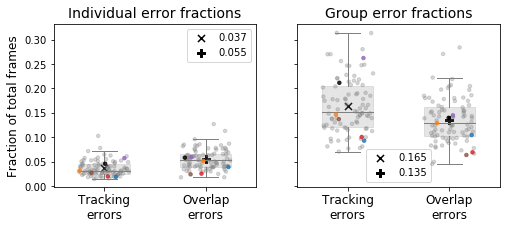

In [64]:

spacing=0.3
ticklabels = ['Tracking\nerrors','Overlap\nerrors']
titles = ['Individual error fractions','Group error fractions']

f,ax = plt.subplots(1,2,sharey=True,sharex=True)
f.set_size_inches(8,3)
for i in range(2):
    a = ax[i]
    errors = [grid_individual_errors, grid_removed_because_of_errors][i]
    a.set_title(titles[i],fontsize=14)
    for j in range(2):
        
        y = errors[:,j]
        x = 0.5*spacing*(np.random.rand(len(y))-0.5) + j*spacing
        bp = a.boxplot(y,positions=[j*spacing],patch_artist=True,showfliers=False)
        for patch in bp['boxes']:
            patch.set(color=focuscolors[1],alpha=0.2)  
        for element in ['whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=focuscolors[tnum])  
        a.scatter(x[notfocus], y[notfocus], s=12,color=np.array(focuscolors)[notfocus], alpha=0.3,zorder=10)
        a.scatter(x[focustreatments], y[focustreatments], s=12,color=np.array(focuscolors)[focustreatments], alpha=0.8,zorder=15)
        a.scatter(j*spacing,np.mean(y),s=50,c='k',marker=['x','P'][j],label=round(np.mean(y),3))

[a.legend() for a in ax]
ax[0].set_xlim([-spacing/2,3/2*spacing])
[a.set_xticks([0,spacing]) for a in ax]
[a.set_xticklabels(ticklabels,fontsize=12) for a in ax]
ax[0].set_ylabel('Fraction of total frames',fontsize=12)

plt.savefig(imagedir+'errorframefractions.pdf')
plt.show()